In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
import fastremap
import cv2

import torch
import torch.nn as nn

from cellpose_v2.models import CellposeModel, Cellpose
from cellpose_v2.io import load_train_test_data
from cellpose_v2.dynamics import labels_to_flow_directions
from cellpose_v2.utils import diameters
from cellpose_v2.transforms import random_rotate_and_resize_directions

In [2]:
BASE_PATH = "../Data/Cellpose/Sartorius"
EXP_PATH = "../Experiments"
MODEL = "cellpose_v2"
DATASET = "sartorius"

## TODO
# osp.join(EXP_PATH, "{}_{}".format(MODEL, DATASET))
save_path = "./run"

In [3]:
train_dir = osp.join(BASE_PATH, "train")
test_dir = osp.join(BASE_PATH, "val")
output = load_train_test_data(train_dir, test_dir=test_dir, mask_filter='_mask')
images, labels, image_names, test_images, test_labels, image_names_test = output
images = [np.concatenate((images[i], np.zeros(images[i].shape)), axis=2).transpose(2, 0, 1) for i in range(len(images))]
labels = [labels[i][0].astype(int) for i in range(len(labels))]
test_images = [np.concatenate((test_images[i], np.zeros(test_images[i].shape)), axis=2).transpose(2, 0, 1) for i in range(len(test_images))]
test_labels = [test_labels[i][0].astype(int) for i in range(len(test_labels))]

In [4]:
###########################################################
## utils.diameters
###########################################################
# def diameters(masks):
#     _, counts = np.unique(np.int32(masks), return_counts=True)
#     counts = counts[1:]
#     md = np.median(counts**0.5)
#     if np.isnan(md):
#         md = 0
#     md /= (np.pi**0.5)/2
#     return md, counts**0.5

###########################################################
## dynamics._extend_centers
###########################################################
# def extend_centers(T, y, x, ymed, xmed, Lx, niter):
#     for t in range(niter):
#         T[ymed*Lx + xmed] += 1
#         T[y*Lx + x] = 1/9. * (T[y*Lx + x] + T[(y-1)*Lx + x]   + T[(y+1)*Lx + x] +
#                                             T[y*Lx + x-1]     + T[y*Lx + x+1] +
#                                             T[(y-1)*Lx + x-1] + T[(y-1)*Lx + x+1] +
#                                             T[(y+1)*Lx + x-1] + T[(y+1)*Lx + x+1])  
#     return T

###########################################################
## dynamics.masks_to_flow_directions
###########################################################
# def masks_to_flow_directions(masks):
#     Ly, Lx = masks.shape
#     mu = np.zeros((2, Ly, Lx), np.float64)
#     mu_c = np.zeros((Ly, Lx), np.float64)
#     mu_d = np.zeros((Ly, Lx), np.int32)
#     slices = scipy.ndimage.find_objects(masks)
#     dia = diameters(masks)[0]
#     s2 = (.15 * dia)**2
#     for i, si in enumerate(slices):
#         if si is not None:
#             sr, sc = si
#             ly, lx = sr.stop - sr.start + 1, sc.stop - sc.start + 1
#             y, x = np.nonzero(masks[sr, sc] == (i+1))
#             y = y.astype(np.int32) + 1
#             x = x.astype(np.int32) + 1
#             ymed = np.median(y)
#             xmed = np.median(x)
#             imin = np.argmin((x-xmed)**2 + (y-ymed)**2)
#             xmed = x[imin]
#             ymed = y[imin]
#             d2 = (x-xmed)**2 + (y-ymed)**2
#             mu_c[sr.start+y-1, sc.start+x-1] = np.exp(-d2/s2)
#             niter = 2*np.int32(np.ptp(x) + np.ptp(y))
#             T = np.zeros((ly+2)*(lx+2), np.float64)
#             T = extend_centers(T, y, x, ymed, xmed, np.int32(lx), np.int32(niter))
#             idx = {}
#             if i == 4:
#                 with np.errstate(divide='ignore', invalid='ignore'):
#                     idx[0] = np.where(np.all([(y-ymed>0), (x-xmed>0), np.arctan((y-ymed)/(x-xmed))<np.pi/8], axis=0))[0]
#                     idx[1] = np.where(np.all([(y-ymed==0), (x-xmed>0)], axis=0))[0]
#                     idx[2] = np.where(np.all([(y-ymed<0), (x-xmed>0), np.arctan((y-ymed)/(x-xmed))>-np.pi/8], axis=0))[0]
#                     idx[3] = np.where(np.all([(y-ymed<0), (x-xmed>0), np.arctan((y-ymed)/(x-xmed))<=-np.pi/8, np.arctan((y-ymed)/(x-xmed))>=-np.pi*3/8], axis=0))[0]      
#                     idx[4] = np.where(np.all([(y-ymed<0), (x-xmed>0), np.arctan((y-ymed)/(x-xmed))<-np.pi*3/8, np.arctan((y-ymed)/(x-xmed))>-np.pi/2], axis=0))[0]
#                     idx[5] = np.where(np.all([(y-ymed<0), (x-xmed == 0)], axis=0))[0]
#                     idx[6] = np.where(np.all([(y-ymed<0), (x-xmed<0), np.arctan((y-ymed)/(x-xmed))<np.pi/2, np.arctan((y-ymed)/(x-xmed))>np.pi*3/8], axis=0))[0]                    
#                     idx[7] = np.where(np.all([(y-ymed<0), (x-xmed<0), np.arctan((y-ymed)/(x-xmed))<=np.pi*3/8, np.arctan((y-ymed)/(x-xmed))>=np.pi/8], axis=0))[0]                   
#                     idx[8] = np.where(np.all([(y-ymed<0), (x-xmed<0), np.arctan((y-ymed)/(x-xmed))<np.pi/8], axis=0))[0]
#                     idx[9] = np.where(np.all([(y-ymed==0), (x-xmed<0)], axis=0))[0]
#                     idx[10] = np.where(np.all([(y-ymed>0), (x-xmed<0), np.arctan((y-ymed)/(x-xmed))>-np.pi/8, np.arctan((y-ymed)/(x-xmed))<0], axis=0))[0]                    
#                     idx[11] = np.where(np.all([(y-ymed>0), (x-xmed<0), np.arctan((y-ymed)/(x-xmed))>=-np.pi*3/8, np.arctan((y-ymed)/(x-xmed))<=-np.pi/8], axis=0))[0]                    
#                     idx[12] = np.where(np.all([(y-ymed>0), (x-xmed<0), np.arctan((y-ymed)/(x-xmed))>-np.pi/2, np.arctan((y-ymed)/(x-xmed))<-np.pi*3/8], axis=0))[0]
#                     idx[13] = np.where(np.all([(y-ymed>0), (x-xmed==0)], axis=0))[0]
#                     idx[14] = np.where(np.all([(y-ymed>0), (x-xmed>0), np.arctan((y-ymed)/(x-xmed))>np.pi*3/8, np.arctan((y-ymed)/(x-xmed))<np.pi/2], axis=0))[0]                    
#                     idx[15] = np.where(np.all([(y-ymed>0), (x-xmed>0), np.arctan((y-ymed)/(x-xmed))>=np.pi/8, np.arctan((y-ymed)/(x-xmed))<=np.pi*3/8], axis=0))[0]                               
#                 tmp_idx = []
#                 for j in range(16):
#                     plt.figure()
#                     plt.title(f"{j}")
#                     tmp = np.zeros((ly, lx), np.float64)
#                     tmp[y, x] = 0.5
#                     tmp_idx = [*tmp_idx, *idx[j]]
#                     tmp[y[tmp_idx], x[tmp_idx]] = 1.0
#                     plt.imshow(tmp)
#                     plt.show()              
#             T[(y+1)*lx + x+1] = np.log(1.+T[(y+1)*lx + x+1])
#             dy = T[(y+1)*lx + x] - T[(y-1)*lx + x]
#             dx = T[y*lx + x + 1] - T[y*lx + x-1]
#             mu[:, sr.start+y-1, sc.start+x-1] = np.stack((dy,dx))            

# def labels_to_flow_directions(labels, files=None, use_gpu=False, device=None, redo_flows=False):
#     nimg = len(labels)
#     if labels[0].ndim < 3:
#         labels = [labels[n][np.newaxis,:,:] for n in range(nimg)]
#     if labels[0].shape[0] == 1 or labels[0].ndim < 3 or redo_flows: # flows need to be recomputed
#         labels = [fastremap.renumber(label, in_place=True)[0] for label in labels]
#         # veci = [masks_to_flow_directions(labels[n][0]) for n in trange(nimg)]
#     masks_to_flow_directions(labels[0][0])

In [5]:
imgs = images[0:8]
flows = labels_to_flow_directions(labels[0:8])
# slices = scipy.ndimage.find_objects(labels[0])
# si = slices[0]
# plt.figure()
# plt.imshow(flows[0][0][si])
# plt.figure()
# plt.imshow(flows[0][1][si])
# plt.figure()
# plt.imshow(flows[0][2][si])
# plt.show()
# print(flows[0][2][si])

100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


In [6]:
# diam_train = np.array([diameters(flows[k][0])[0] for k in range(len(flows))])
# diam_train_mean = diam_train[diam_train > 0].mean()
# diam_train[diam_train<5] = 5.            
# scale_range = 0.5
# diam_mean = 17.
# rsc = diam_train / diam_mean

In [7]:
# def random_rotate_and_resize(X, Y=None, scale_range=1., xy = (224,224), do_flip=True, rescale=None, unet=False, random_per_image=True):
#     scale_range = max(0, min(2, float(scale_range)))
#     nimg = len(X)
#     if X[0].ndim>2:
#         nchan = X[0].shape[0]
#     else:
#         nchan = 1
#     imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)
#     lbl = []
#     if Y is not None:
#         if Y[0].ndim>2:
#             nt = Y[0].shape[0]
#         else:
#             nt = 1
#         lbl = np.zeros((nimg, nt, xy[0], xy[1]), np.float32)
#     scale = np.ones(nimg, np.float32)
#     for n in range(nimg):
#         Ly, Lx = X[n].shape[-2:]
#         if random_per_image or n==0:
#             flip = np.random.rand()>.5
#             theta = np.random.rand() * np.pi * 2
#             scale[n] = (1-scale_range/2) + scale_range * np.random.rand()
#             if rescale is not None:
#                 scale[n] *= 1. / rescale[n]
#             dxy = np.maximum(0, np.array([Lx*scale[n]-xy[1],Ly*scale[n]-xy[0]]))
#             dxy = (np.random.rand(2,) - .5) * dxy
#             cc = np.array([Lx/2, Ly/2])
#             cc1 = cc - np.array([Lx-xy[1], Ly-xy[0]])/2 + dxy
#             pts1 = np.float32([cc,cc + np.array([1,0]), cc + np.array([0,1])])
#             pts2 = np.float32([cc1,
#                     cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
#                     cc1 + scale[n]*np.array([np.cos(np.pi/2+theta), np.sin(np.pi/2+theta)])])
#             M = cv2.getAffineTransform(pts1,pts2)
#         img = X[n].copy()
#         if Y is not None:
#             labels = Y[n].copy()
#             if labels.ndim<3:
#                 labels = labels[np.newaxis,:,:]
#         if flip and do_flip:
#             img = img[..., ::-1]
#             if Y is not None:
#                 labels = labels[..., ::-1]
#                 if nt > 1 and not unet:
#                     labels[2] = -labels[2]
#         for k in range(nchan):
#             I = cv2.warpAffine(img[k], M, (xy[1],xy[0]), flags=cv2.INTER_LINEAR)
#             imgi[n,k] = I
#         if Y is not None:
#             for k in range(nt):
#                 if k==0 or k==2:
#                     lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1],xy[0]), flags=cv2.INTER_NEAREST)
#                 else:
#                     lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1],xy[0]), flags=cv2.INTER_LINEAR)
#             if nt > 1 and not unet:
#                 v1 = lbl[n,2].copy()
#                 v2 = lbl[n,1].copy()
#                 lbl[n,1] = (-v1 * np.sin(-theta) + v2*np.cos(-theta))
#                 lbl[n,2] = (v1 * np.cos(-theta) + v2*np.sin(-theta))
#     return imgi, lbl, scale

# imgi, lbl, scale = random_rotate_and_resize(imgs, flows, rescale=rsc, scale_range=scale_range, unet=True)
# plt.figure()
# plt.imshow(imgs[0][0])
# plt.figure()
# plt.imshow(flows[0][2])
# plt.figure()
# plt.imshow(imgi[0][0])
# plt.figure()
# plt.imshow(lbl[0][0])
# plt.figure()
# plt.imshow(lbl[0][2])
# plt.show()

In [8]:
# slices = scipy.ndimage.find_objects(flows[7][0].astype(int))
# si = slices[0]
# print(si)
# print(lbl[0][0].shape)
# plt.figure()
# plt.imshow(lbl[0][0][si])
# plt.figure()
# plt.imshow(lbl[0][1][si])
# plt.figure()
# plt.imshow(lbl[0][2][si])
# plt.show()
# print(lbl[0][2][si])

## New

(3, 520, 704)


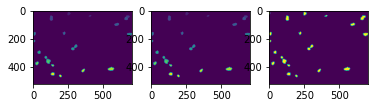

In [9]:
print(flows[0].shape)
img_id = 6
plt.figure()
plt.imshow(flows[img_id][0])
plt.figure()
plt.imshow(flows[img_id][0])
plt.figure()
plt.imshow(flows[img_id][1])
plt.show()

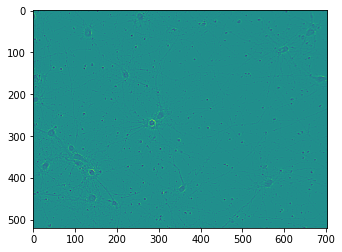

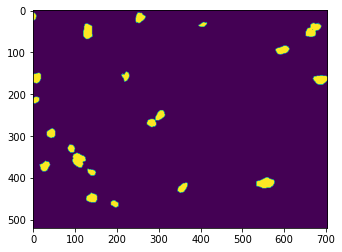

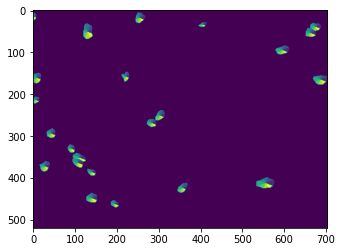

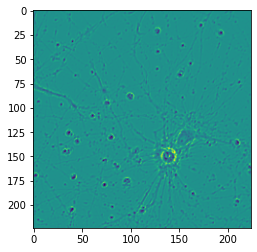

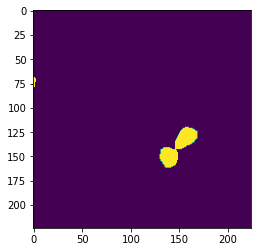

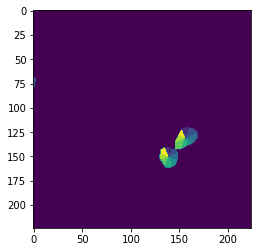

In [18]:
diam_train = np.array([diameters(flows[k][0])[0] for k in range(len(flows))])
diam_train_mean = diam_train[diam_train > 0].mean()
diam_train[diam_train<5] = 5.
scale_range = 0.5
diam_mean = 17.
rsc = diam_train / diam_mean

lbls = [f[1:] for f in flows]

img_id = 6
plt.figure()
plt.imshow(imgs[img_id][0])
plt.figure()
plt.imshow(lbls[img_id][0])
plt.figure()
plt.imshow(lbls[img_id][1])
plt.show()

imgi, lbli, scale = random_rotate_and_resize_directions(imgs, lbls, rescale=rsc, scale_range=scale_range, unet=True)

img_id = 6
plt.figure()
plt.imshow(imgi[img_id][0])
plt.figure()
plt.imshow(lbli[img_id][0])
plt.figure()
plt.imshow(lbli[img_id][1])
plt.show()

In [11]:
print(np.unique(lbli[img_id][1]))

[-1.  5.  6.]


In [16]:
bs = 8
nclass = 9
_, h, w = lbli[img_id].shape
y = torch.randn((bs, nclass, h, w))

t1 = torch.from_numpy(lbli[:,1]).long()
t2 = torch.from_numpy(lbli[:,0]>.5).float()

criterion1  = nn.CrossEntropyLoss(reduction='mean', ignore_index = - 1)
criterion2 = nn.BCEWithLogitsLoss(reduction='mean')
loss1 = criterion1(y[:,0:8], t1)
loss2 = criterion2(y[:,8], t2)

In [17]:
print(loss1, loss2)

tensor(2.4933) tensor(0.8056)
